Data obtained from project "abstract"
```python
epochs[-1].get_data().shape # The Epochs object of the last subject in numpy array

e = epochs[-1][["img","sf","toon"]]

X = e.get_data()[:,:28,:]
Y = get_labels_from_events(e.events, e.event_id)

X.shape

assert X.shape[0] == Y.shape[0]

with open("subj28.pkl", "wb") as f:
    pickle.dump(epochs[-1], f, protocol=pickle.HIGHEST_PROTOCOL)
```



.File "subj28.pkl" is a pickled tuple of two numpy arrays: X and Y. X has shape (797 epochs, 28 channels, 501 samples) and Y has shape (797, 4). It is three experimental categories and five affective classes one-hot-encoded into 4 dimensions. 

```python
    m = {"0": np.array([ 0, 0]),
        "1": np.array([ 1, 1]),
        "2": np.array([-1, 1]),
        "3": np.array([-1,-1]),
        "4": np.array([ 1,-1])}
    c = {"img": np.array([0, 0]),
        "sf":   np.array([1, 0]),
        "toon": np.array([0, 1])}
```

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import mne

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.utils import gen_batches

import torch
from torch import nn
import torch.nn.functional as F
import torchmetrics

In [2]:
from torch.autograd import Variable
accuracy = torchmetrics.Accuracy()

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/Subj28EEGNet")

In [3]:
with open("ex/subj28.pkl", 'rb') as f:
    X,Y = pickle.load(f)
print(X.shape)
print(Y.shape)

(797, 28, 501)
(797, 4)


In [4]:
print(Y)

[[ 1  0  1  1]
 [ 1  0  1  1]
 [ 1  0  1  1]
 ...
 [ 0  1  0  0]
 [ 0  1  0  0]
 [ 0  0 -1  1]]


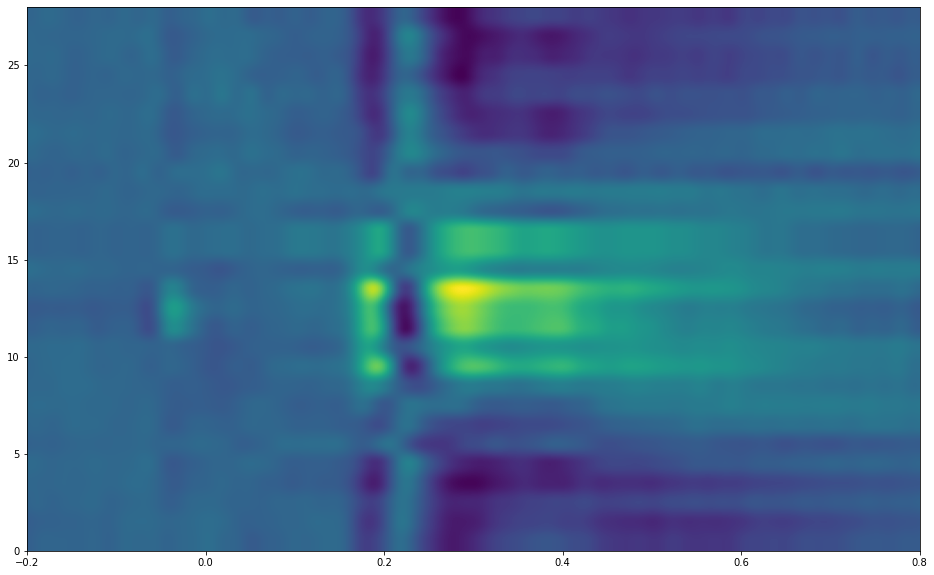

In [5]:
fs = 500
tmin = -0.200
tmax = 0.800
ch_names = ['Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'Cz', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'Pz', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']
t = np.linspace(tmin, tmax, X.shape[2])
fig, ax = plt.subplots(figsize=(16,10))
ax.imshow(X.mean(axis=0), extent=[tmin, tmax,0,28], interpolation=None)
ax.set_aspect("auto")
plt.show()

Simplest attempt, every sample in every channel is a variable observed on every trial.

In [6]:
n_channels = X.shape[1]
n_samples = X.shape[2]
X = X.reshape(797,-1)
print(X.shape)

(797, 14028)


In [7]:
Y = Y[:, 2:].astype("int")
print(Y.shape)
print(f"Category POS {sum(np.logical_or((Y == [1, 1]).all(axis=1), (Y == [1, -1]).all(axis=1)))}")
print(f"Category NTR {sum((Y == [0, 0]).all(axis=1))}")
print(f"Category NEG {sum(np.logical_or((Y == [-1, 1]).all(axis=1), (Y == [-1, -1]).all(axis=1)))}")

(797, 2)
Category POS 601
Category NTR 123
Category NEG 73


In [8]:
naive_model_level = 601/(601 + 123 + 73)

(797, 14028)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


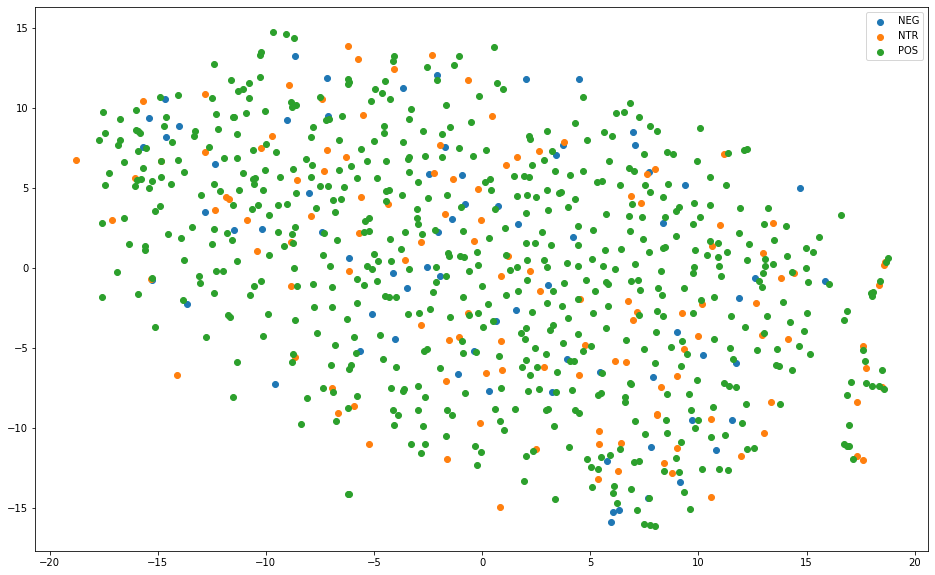

In [9]:
print(X.shape)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
fig = plt.figure(figsize=(16,10))
cmap = plt.cm.get_cmap('tab10')

plt.scatter(X_embedded[Y[:,0]==-1,0], X_embedded[Y[:,0]==-1,1], c=cmap(0), label="NEG")
plt.scatter(X_embedded[Y[:,0]==0,0], X_embedded[Y[:,0]==0,1], c=cmap(1), label="NTR")
plt.scatter(X_embedded[Y[:,0]==1,0], X_embedded[Y[:,0]==1,1], c=cmap(2), label="POS")

plt.legend()

The features don't seem to be linearly separable, so a high accuracy is not expected.

In [10]:
X = X.reshape(797,n_channels,n_samples)[:,None,:,:]

Pytorch loss function uses the Y vector with categories encoded as numbers.

In [11]:
n_classes = 3
print(n_classes)
Y = Y[:,0]+1
print(Y.shape)

3
(797,)


A 70/30 split is done for testing and training purposes. This evaluates the model's generalizability.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
Y_train, Y_test = y_train, y_test

## The model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
print('Using device:', device)

Using device: cuda


In [14]:
class EEGNet(nn.Module):
    """The model implements EEGNet network https://arxiv.org/abs/1611.08024

    Parameters
    ----------
    spatial_dim : int
        Number of channels
    """
    def __init__(self, n_channels, n_classes):
        super(EEGNet, self).__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.T = 120
        
        # Layer 1 / Spatial
        self.conv1 = nn.Conv2d(1, 16, (n_channels, 1), padding = 0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((1, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32), bias=False)
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(240, n_classes),
            nn.LogSoftmax(dim=1),
        )

        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = x.permute(0, 2, 1, 3)
        x = F.dropout(x, 0.25)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.pooling2(x)
        x = F.dropout(x, 0.25)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pooling3(x)
        x = F.dropout(x, 0.25)

        
        # Classifier
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def init(self, init_func, *params, **kwargs):
        for p in self.parameters():
            init_func(p, *params, **kwargs)



In [15]:
model = EEGNet(n_channels, n_classes)
model.to(device)

x = Variable(torch.tensor(X.astype(np.float32))).to(device)
model.eval()

print(x.size())
x = F.elu(model.conv1(x))
print(x.size())
x = model.batchnorm1(x)
print(x.size())
x = x.permute(0, 2, 1, 3)
print(x.size())


x = model.padding1(x)
print(x.size())
x = F.elu(model.conv2(x))
print(x.size())
x = model.batchnorm2(x)
print(x.size())
x = model.pooling2(x)
print(x.size())


x = model.padding2(x)
print(x.size())
x = F.elu(model.conv3(x))
print(x.size())
x = model.batchnorm3(x)
print(x.size())
x = F.dropout(x, 0.25)
print(x.size())
x = model.pooling3(x)
print(x.size())

x = x.view(x.size(0), -1)
print(x.size())
model.train()

torch.Size([797, 1, 28, 501])
torch.Size([797, 16, 1, 501])
torch.Size([797, 16, 1, 501])
torch.Size([797, 1, 16, 501])
torch.Size([797, 1, 17, 519])
torch.Size([797, 4, 16, 488])
torch.Size([797, 4, 16, 488])
torch.Size([797, 4, 4, 122])
torch.Size([797, 4, 11, 125])
torch.Size([797, 4, 4, 122])
torch.Size([797, 4, 4, 122])
torch.Size([797, 4, 4, 122])
torch.Size([797, 4, 2, 30])
torch.Size([797, 240])


EEGNet(
  (conv1): Conv2d(1, 16, kernel_size=(28, 1), stride=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(16, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (padding1): ZeroPad2d((1, 17, 0, 1))
  (conv2): Conv2d(1, 4, kernel_size=(2, 32), stride=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(4, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (pooling2): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (padding2): ZeroPad2d((2, 1, 4, 3))
  (conv3): Conv2d(4, 4, kernel_size=(8, 4), stride=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(4, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (pooling3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=240, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [16]:
n_channels = 28 
n_classes = 3
learningRate = 0.01 
epochs = 200
batch_size = 20
model = EEGNet(n_channels, n_classes)
model.to(device)

EEGNet(
  (conv1): Conv2d(1, 16, kernel_size=(28, 1), stride=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(16, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (padding1): ZeroPad2d((1, 17, 0, 1))
  (conv2): Conv2d(1, 4, kernel_size=(2, 32), stride=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(4, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (pooling2): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (padding2): ZeroPad2d((2, 1, 4, 3))
  (conv3): Conv2d(4, 4, kernel_size=(8, 4), stride=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(4, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (pooling3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=240, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [17]:
for name, param in model.named_parameters():
    print(name, param.size())

conv1.weight torch.Size([16, 1, 28, 1])
batchnorm1.weight torch.Size([16])
batchnorm1.bias torch.Size([16])
conv2.weight torch.Size([4, 1, 2, 32])
batchnorm2.weight torch.Size([4])
batchnorm2.bias torch.Size([4])
conv3.weight torch.Size([4, 4, 8, 4])
batchnorm3.weight torch.Size([4])
batchnorm3.bias torch.Size([4])
classifier.0.weight torch.Size([3, 240])
classifier.0.bias torch.Size([3])


In [18]:
model = EEGNet(n_channels, n_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
accuracy.to(device)

ltr_curve, atr_curve = [], []
lts_curve, ats_curve = [], []
model.init(nn.init.uniform_)
for epoch in range(epochs):
    batches = gen_batches(X_train.shape[0], batch_size)
    places = np.arange(X_train.shape[0])
    np.random.shuffle(places)
    batch_ltr, batch_atr = [], []
    batch_lts, batch_ats = [], []
    for i in batches:
        # Train Set
        inputs = Variable(torch.tensor(X_train[places[i]].astype(np.float32))).to(device)
        labels = Variable(torch.tensor(y_train[places[i]].astype(np.float32))).to(device).long()

        optimizer.zero_grad()
        y_hat = model(inputs)

        loss = criterion(y_hat, labels)
        train_loss = loss.item()
        batch_ltr.append(train_loss)

        train_acc = accuracy(y_hat, labels.int())
        batch_atr.append(train_acc.cpu().detach().numpy())

        # Optimization
        loss.backward()
        optimizer.step()
    ltr_curve.append(np.mean(batch_ltr))
    atr_curve.append(np.mean(batch_atr))

    with torch.no_grad():
        # Test set
        model.eval()
        places = np.arange(X_test.shape[0])
        batches = gen_batches(X_test.shape[0], batch_size)
        np.random.shuffle(places)
        for i in batches:
            y_hat = model(Variable(torch.tensor(X_test[places[i]].astype(np.float32))).to(device))
            test_lbls = Variable(torch.tensor(y_test[places[i]].astype(np.float32))).to(device)
            test_loss = criterion(y_hat, test_lbls.long())
            test_loss = test_loss.item()
            batch_lts.append(test_loss)
            test_acc = accuracy(y_hat, test_lbls.int())
            batch_ats.append(test_acc.cpu().detach().numpy())
        lts_curve.append(np.mean(batch_lts))
        ats_curve.append(np.mean(batch_ats))
    model.train()
    print(f"epoch {epoch}, loss {loss.item()}, Acc_tst: {ats_curve[-1]}") # 

epoch 0, loss 2.4573848247528076, Acc_tst: 0.512499988079071
epoch 1, loss 0.7469561100006104, Acc_tst: 0.6499999761581421
epoch 2, loss 0.9978135228157043, Acc_tst: 0.7166666984558105
epoch 3, loss 0.7002425789833069, Acc_tst: 0.6916666626930237
epoch 4, loss 0.7295112609863281, Acc_tst: 0.7958333492279053
epoch 5, loss 1.0390855073928833, Acc_tst: 0.7916667461395264
epoch 6, loss 0.8890195488929749, Acc_tst: 0.79583340883255
epoch 7, loss 0.7238725423812866, Acc_tst: 0.7916667461395264
epoch 8, loss 0.7010684013366699, Acc_tst: 0.8041666150093079
epoch 9, loss 0.7485702037811279, Acc_tst: 0.7958333492279053
epoch 10, loss 0.8586323261260986, Acc_tst: 0.8083333373069763
epoch 11, loss 0.6277431845664978, Acc_tst: 0.8041667342185974
epoch 12, loss 0.9060315489768982, Acc_tst: 0.8041666150093079
epoch 13, loss 0.42560410499572754, Acc_tst: 0.8041666150093079
epoch 14, loss 0.9492435455322266, Acc_tst: 0.8041666150093079
epoch 15, loss 0.7010822892189026, Acc_tst: 0.8041666150093079
epoc

epoch 130, loss 1.2022734880447388, Acc_tst: 0.8041667342185974
epoch 131, loss 0.5650162100791931, Acc_tst: 0.8041667342185974
epoch 132, loss 0.6395804286003113, Acc_tst: 0.8041666150093079
epoch 133, loss 0.8280236124992371, Acc_tst: 0.8041666150093079
epoch 134, loss 1.0722460746765137, Acc_tst: 0.8041666150093079
epoch 135, loss 0.8048271536827087, Acc_tst: 0.8041667342185974
epoch 136, loss 0.7805018424987793, Acc_tst: 0.8041667342185974
epoch 137, loss 1.1115350723266602, Acc_tst: 0.8041667342185974
epoch 138, loss 1.1642850637435913, Acc_tst: 0.8041666150093079
epoch 139, loss 1.0169199705123901, Acc_tst: 0.8041666150093079
epoch 140, loss 0.7780167460441589, Acc_tst: 0.8041667342185974
epoch 141, loss 0.5666150450706482, Acc_tst: 0.8041666150093079
epoch 142, loss 0.4954947233200073, Acc_tst: 0.8041667342185974
epoch 143, loss 0.730135977268219, Acc_tst: 0.8041667342185974
epoch 144, loss 0.7385367751121521, Acc_tst: 0.8041666150093079
epoch 145, loss 0.7894549369812012, Acc_t

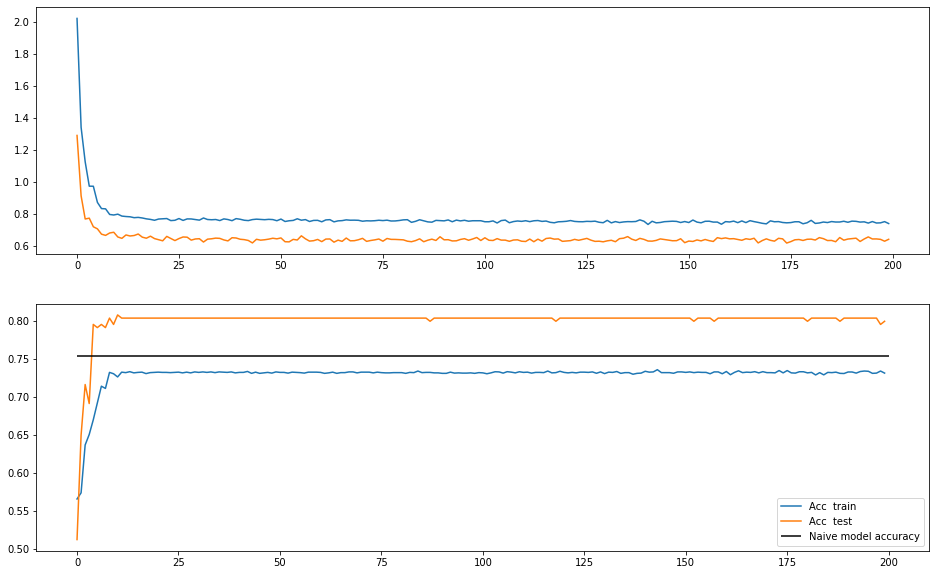

In [19]:
fig, axs = plt.subplots(2, figsize=(16,10))
axs[0].plot(ltr_curve, label="Loss train")
axs[1].plot(atr_curve, label="Acc  train")
axs[0].plot(lts_curve, label="Loss test")
axs[1].plot(ats_curve, label="Acc  test")
axs[1].hlines([naive_model_level], 0, len(ats_curve), colors='k', linestyles='solid', label='Naive model accuracy')
# axs[0].set_ylim((0,2))
plt.legend()
plt.show()

# Visualization

In [20]:
coef = [p.cpu().detach().numpy() for p in model.parameters()]
print(len(coef))
for i, c in enumerate(coef):
    print(f"Layer: {i}, weights: {c.shape}")

11
Layer: 0, weights: (16, 1, 28, 1)
Layer: 1, weights: (16,)
Layer: 2, weights: (16,)
Layer: 3, weights: (4, 1, 2, 32)
Layer: 4, weights: (4,)
Layer: 5, weights: (4,)
Layer: 6, weights: (4, 4, 8, 4)
Layer: 7, weights: (4,)
Layer: 8, weights: (4,)
Layer: 9, weights: (3, 240)
Layer: 10, weights: (3,)


In [21]:
print(coef[0].shape)
W = coef[0].squeeze()
print(W.shape)

(16, 1, 28, 1)
(16, 28)


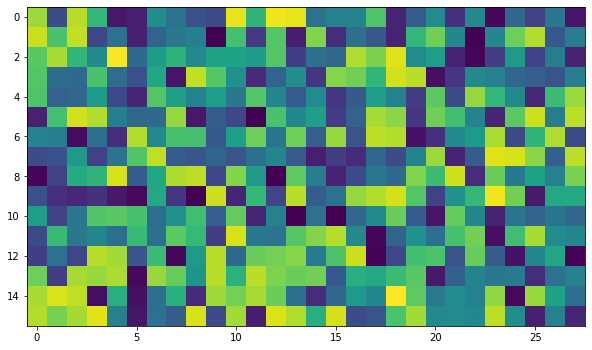

In [22]:
fig = plt.figure(figsize=(10,10))
plt.imshow(W)

These are 16 CSPs learned by the first layer of the network:

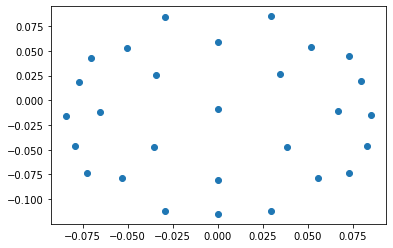

In [23]:
from mne.viz import plot_topomap
layout = mne.channels.make_standard_montage('standard_1020').get_positions()["ch_pos"]
chs = ['Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'Cz', 
       'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'Pz', 
       'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 
       'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']
pos = np.vstack([layout[i] for i in chs])
plt.scatter(pos[:,0], pos[:,1])
plt.show()

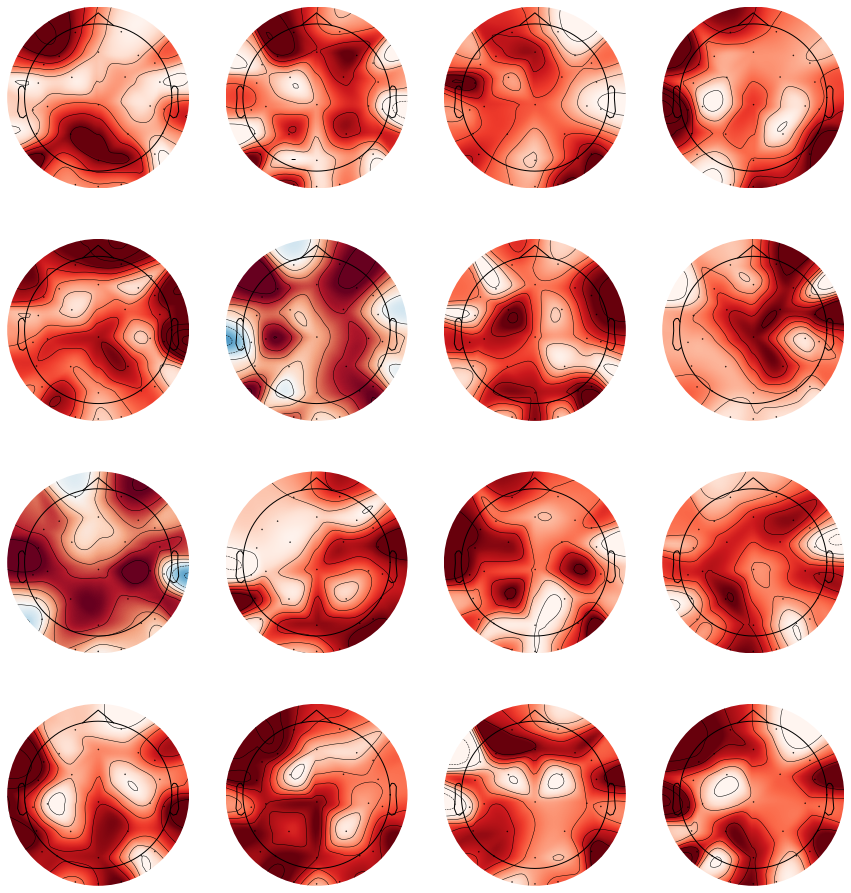

In [24]:
n_components = 16
fig, axs = plt.subplots(4,4, figsize=(15,15))
i = 0
for row in axs:
    for ax in row:
        plot_topomap(W[i,:], pos[:,:2], axes=ax, show=False)
        i += 1
fig.show()

Not much more interpretability, as long as parameters don't match neurophysiological variables.

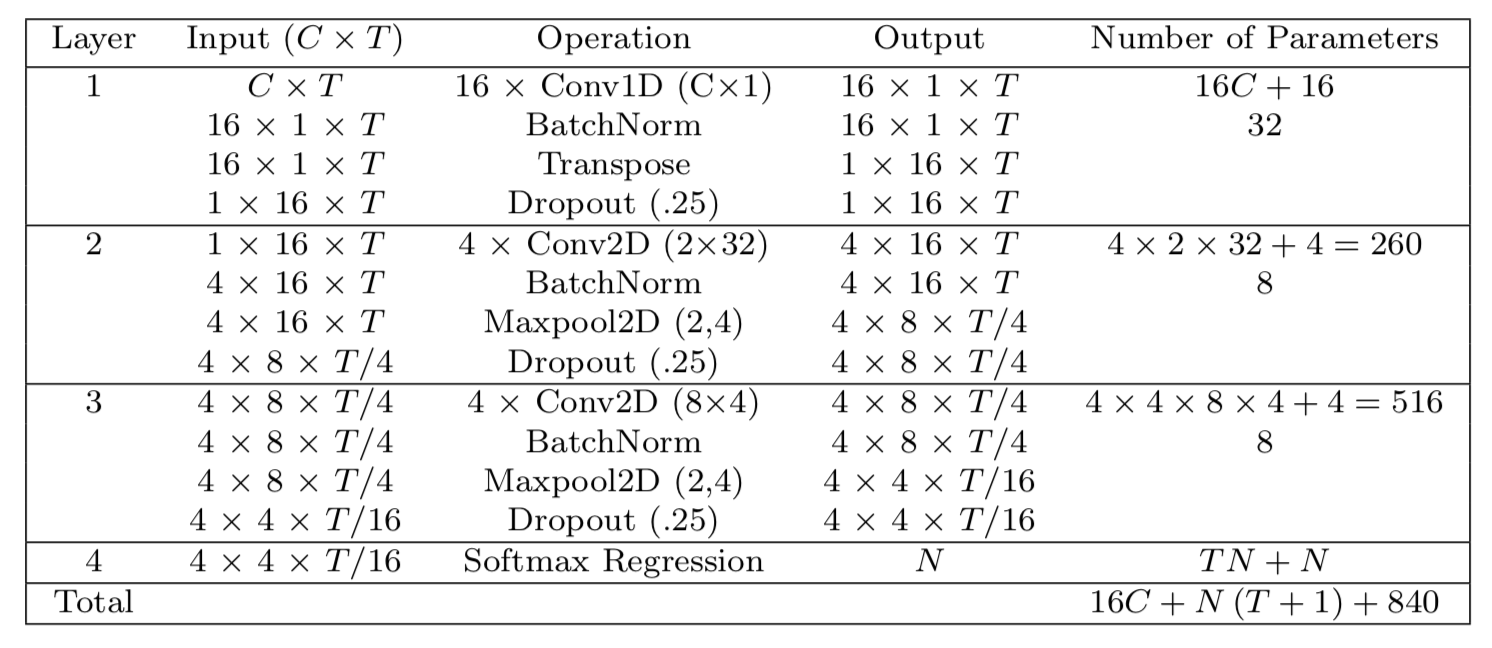

In [25]:
model.eval()
x = Variable(torch.tensor(X.astype(np.float32))).to(device)
print(x.size())
x = F.elu(model.conv1(x))
print(x.size())
x = model.batchnorm1(x)
print(x.size())
x = F.dropout(x, 0.25)
print(x.size())
x = x.permute(0, 2, 1, 3)
print(x.size())


x = model.padding1(x)
print(x.size())
x = F.elu(model.conv2(x))
print(x.size())
x = model.batchnorm2(x)
print(x.size())
x = F.dropout(x, 0.25)
print(x.size())
x = model.pooling2(x)
print(x.size())


x = model.padding2(x)
print(x.size())
x = F.elu(model.conv3(x))
print(x.size())
x = model.batchnorm3(x)
print(x.size())
x = F.dropout(x, 0.25)
print(x.size())
x = model.pooling3(x)
print(x.size())

x = x.view(x.size(0), -1)
print(x.size())
model.train()

torch.Size([797, 1, 28, 501])
torch.Size([797, 16, 1, 501])
torch.Size([797, 16, 1, 501])
torch.Size([797, 16, 1, 501])
torch.Size([797, 1, 16, 501])
torch.Size([797, 1, 17, 519])
torch.Size([797, 4, 16, 488])
torch.Size([797, 4, 16, 488])
torch.Size([797, 4, 16, 488])
torch.Size([797, 4, 4, 122])
torch.Size([797, 4, 11, 125])
torch.Size([797, 4, 4, 122])
torch.Size([797, 4, 4, 122])
torch.Size([797, 4, 4, 122])
torch.Size([797, 4, 2, 30])
torch.Size([797, 240])


EEGNet(
  (conv1): Conv2d(1, 16, kernel_size=(28, 1), stride=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(16, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (padding1): ZeroPad2d((1, 17, 0, 1))
  (conv2): Conv2d(1, 4, kernel_size=(2, 32), stride=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(4, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (pooling2): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (padding2): ZeroPad2d((2, 1, 4, 3))
  (conv3): Conv2d(4, 4, kernel_size=(8, 4), stride=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(4, eps=False, momentum=0.1, affine=True, track_running_stats=True)
  (pooling3): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=240, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [26]:
X_embedded = x.cpu().detach().numpy()
X_embedded = X_embedded.squeeze()
print(X_embedded.shape)

(797, 240)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


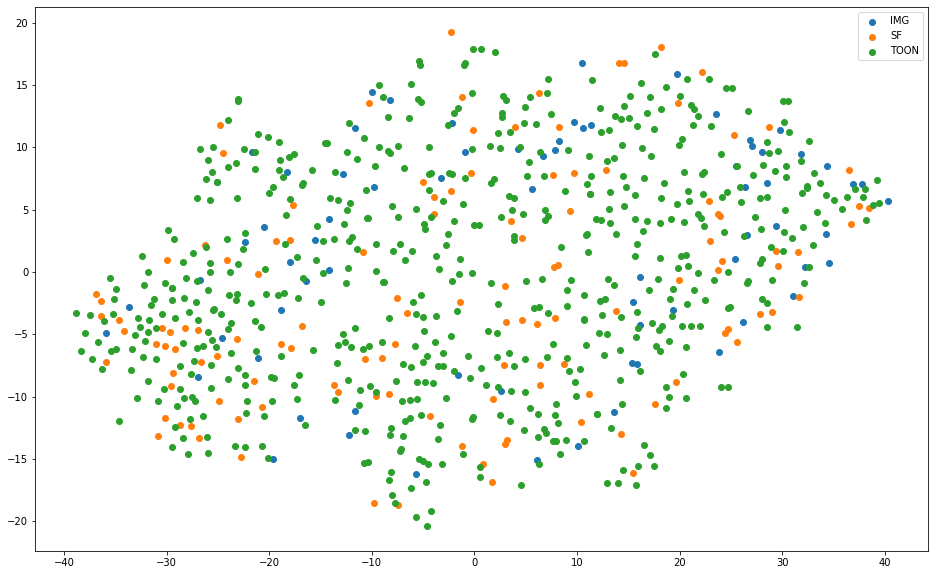

In [27]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_embedded)
fig = plt.figure(figsize=(16,10))
cmap = plt.cm.get_cmap('tab10')
plt.scatter(X_embedded[Y==0,0], X_embedded[Y==0,1], c=cmap(0), label="IMG")
plt.scatter(X_embedded[Y==1,0], X_embedded[Y==1,1], c=cmap(1), label="SF")
plt.scatter(X_embedded[Y==2,0], X_embedded[Y==2,1], c=cmap(2), label="TOON")

plt.legend()

# Cross-validation

In [28]:
n_channels = 28 
n_classes = 3
learningRate = 0.01
batch_size = 512
epochs = 75 # Early stopping

accuracy.to(device)

kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [29]:
X_train.shape

(557, 1, 28, 501)

In [30]:
def train_model(X_train, Y_train, X_test, Y_test):
    model = EEGNet(n_channels, n_classes)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
    accuracy.to(device)

    ltr_curve, atr_curve = [], []
    lts_curve, ats_curve = [], []
    model.init(nn.init.uniform_)
    for epoch in range(epochs):   
        batches = gen_batches(X_train.shape[0], batch_size)
        places = np.arange(X_train.shape[0])
        np.random.shuffle(places)
        batch_ltr, batch_atr = [], []
        batch_lts, batch_ats = [], []
        for i in batches:
            # Train Set
            inputs = Variable(torch.tensor(X_train[places[i]].astype(np.float32))).to(device)
            labels = Variable(torch.tensor(Y_train[places[i]].astype(np.float32))).to(device).long()

            optimizer.zero_grad()
            y_hat = model(inputs)


            loss = criterion(y_hat, labels)
            train_loss = loss.item()
            
            batch_ltr.append(train_loss)

            train_acc = accuracy(y_hat, labels.int())
            batch_atr.append(train_acc.cpu().detach().numpy())

            # Optimization
            loss.backward()
            optimizer.step()
        ltr_curve.append(np.mean(batch_ltr))
        atr_curve.append(np.mean(batch_atr))
        
        with torch.no_grad():
            # Test set
            model.eval()
            places = np.arange(X_test.shape[0])
            batches = gen_batches(X_test.shape[0], batch_size)
            np.random.shuffle(places)
            for i in batches:
                y_hat = model(Variable(torch.tensor(X_test[places[i]].astype(np.float32))).to(device))
                test_lbls = Variable(torch.tensor(y_test[places[i]].astype(np.float32))).to(device)
                test_loss = criterion(y_hat, test_lbls.long())
                test_loss = test_loss.item()
                batch_lts.append(test_loss)
                test_acc = accuracy(y_hat, test_lbls.int())
                batch_ats.append(test_acc.cpu().detach().numpy())
            lts_curve.append(np.mean(batch_lts))
            ats_curve.append(np.mean(batch_ats))
        model.train()
    return np.hstack(ats_curve).mean()

```python
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
```

loss 0.7574166655540466
loss 0.7210833430290222
loss 0.7033124566078186
loss 0.6929978728294373
loss 0.6862053871154785


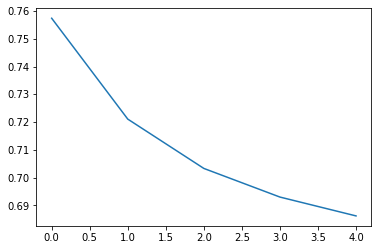

In [31]:
cvl = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index]
#     print("TRAIN:", X_train.shape, "TEST:", X_test.shape)
#     print("TRAIN:", Y_train.shape, "TEST:", Y_test.shape)
    cvl.append(train_model(X_train, Y_train, X_test, Y_test))
    print('loss {}'.format(cvl[-1]))
plt.plot(cvl)

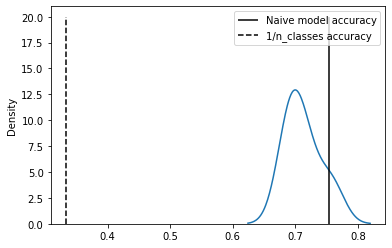

In [32]:
cross_validation_scores = cvl
sns.kdeplot(cvl)
plt.vlines([naive_model_level], 0, 20, colors='k', linestyles='solid', label='Naive model accuracy')
plt.vlines([1/n_classes], 0, 20, colors='k', linestyles='--', label='1/n_classes accuracy')

plt.legend()


Training 0, loss: 0.6909853219985962

Training 1, loss: 0.6743815541267395

Training 2, loss: 0.6915723085403442

Training 3, loss: 0.6648218035697937

Training 4, loss: 0.7145492434501648

Training 5, loss: 0.6947588920593262

Training 6, loss: 0.641593337059021

Training 7, loss: 0.7035639882087708

Training 8, loss: 0.6743814945220947

Training 9, loss: 0.7168134450912476


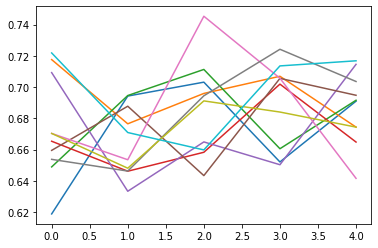

In [33]:
N_perm = 10
chance_cvl = []
for i in range(N_perm):
    print()
    cvl = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index,:], X[test_index,:]
        Y_ = np.random.permutation(Y)
        Y_train, Y_test = Y_[train_index], Y_[test_index]
    #     print("TRAIN:", X_train.shape, "TEST:", X_test.shape)
    #     print("TRAIN:", Y_train.shape, "TEST:", Y_test.shape)
        cvl.append(train_model(X_train, Y_train, X_test, Y_test))
    plt.plot(cvl)
    print(f"Training {i}, loss: {cvl[-1]}")
    chance_cvl.append(cvl)

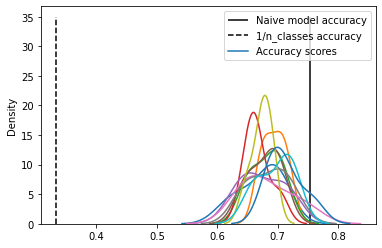

In [34]:
plt.vlines([naive_model_level], 0, 35, colors='k', linestyles='solid', label='Naive model accuracy')
plt.vlines([1/n_classes], 0, 35, colors='k', linestyles='--', label='1/n_classes accuracy')
for i in chance_cvl:
    sns.kdeplot(i)
sns.kdeplot(cross_validation_scores, label="Accuracy scores")
plt.legend()

In [35]:
chance_scores = np.array(chance_cvl).reshape(-1)
chance_scores

array([0.61883336, 0.69425005, 0.7031446 , 0.65207547, 0.6909853 ,
       0.71758324, 0.67649996, 0.6959329 , 0.7069183 , 0.67438155,
       0.6489167 , 0.69458336, 0.7112789 , 0.6605451 , 0.6915723 ,
       0.66533333, 0.6461666 , 0.65828097, 0.7018868 , 0.6648218 ,
       0.70925   , 0.6333333 , 0.66490567, 0.6503145 , 0.71454924,
       0.6595    , 0.68775   , 0.64335436, 0.7055766 , 0.6947589 ,
       0.6703333 , 0.6535001 , 0.7453251 , 0.70566034, 0.64159334,
       0.6537499 , 0.64625   , 0.6944235 , 0.72419286, 0.703564  ,
       0.6703333 , 0.64808327, 0.691153  , 0.6840252 , 0.6743815 ,
       0.72183335, 0.6709166 , 0.65979034, 0.713543  , 0.71681345],
      dtype=float32)

In [36]:
cross_validation_scores = np.array(cross_validation_scores)
cross_validation_scores

array([0.75741667, 0.72108334, 0.70331246, 0.6929979 , 0.6862054 ],
      dtype=float32)

In [37]:
conf_int = np.quantile(chance_scores, 0.95)
print(conf_int)

0.7199207991361618


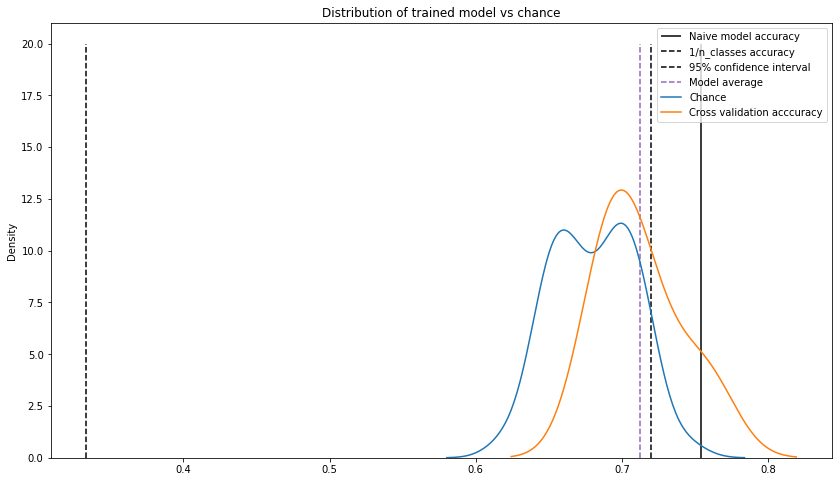

In [38]:
fig = plt.figure(figsize=(14,8))
plt.vlines([naive_model_level], 0, 20, colors='k', linestyles='solid', label='Naive model accuracy')
plt.vlines([1/n_classes], 0, 20, colors='k', linestyles='--', label='1/n_classes accuracy')
plt.vlines([conf_int], 0, 20, colors='k', linestyles='dashed', label='95% confidence interval')
plt.vlines([cross_validation_scores.mean()], 0, 20, colors='C4', linestyles='dashed', label='Model average')
sns.kdeplot(chance_scores, label="Chance")
sns.kdeplot(cross_validation_scores, label="Cross validation acccuracy")
plt.title("Distribution of trained model vs chance")
plt.legend()

In [39]:
from scipy.stats import mannwhitneyu, ttest_ind
U, p = mannwhitneyu(chance_scores, cross_validation_scores)
print(U, p)

60.0 0.05897217697916379


In [40]:
t, p = ttest_ind(chance_scores, cross_validation_scores)
print(t, p)

-2.397386671008364 0.02006903532988858
